# TELECOM CHURN PREDICTION

## INTRODUCTION
In this project, we developed a predictive model for customer churn using different models and choosing the best one for our use case. To interpret the model's decisions and identify the most influential features driving churn, we used SHAP (SHapley Additive exPlanations), which provided clear insights into feature importance and model behavior.


### CREATING THE DATAFRAME
I have used a publicly available dataset from Hugging Face to train and evaluate the model. 

In [1]:
import pandas as pd

url = "https://huggingface.co/datasets/aai510-group1/telco-customer-churn/resolve/c18fe6295a6ca80ca26627a6627c6f11ccd21d86/train.csv"

#Load directly into a DataFrame
df = pd.read_csv(url)
df_original = pd.read_csv(url)
#View a sample
df.head()

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn Category,Churn Reason,Churn Score,City,CLTV,Contract,Country,...,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code,Churn
0,72,4,19.44,NaN,NaN,51,San Mateo,4849,Two Year,United States,...,25,2191.15,0,486.00,0.0,2677.15,0,1,94403,0
1,27,59,45.62,NaN,NaN,27,Sutter Creek,3715,Month-to-Month,United States,...,35,3418.20,0,1596.70,0.0,5014.90,1,1,95685,0
2,59,0,16.07,NaN,NaN,59,Santa Cruz,5092,Month-to-Month,United States,...,46,851.20,0,739.22,0.0,1590.42,0,0,95064,0
3,25,27,0.00,NaN,NaN,49,Brea,2068,One Year,United States,...,27,1246.40,30,0.00,0.0,1276.40,1,0,92823,0
4,31,21,17.22,Dissatisfaction,Network reliability,88,San Jose,4026,One Year,United States,...,58,3563.80,0,998.76,0.0,4562.56,0,1,95117,1


In [2]:
df.shape

(4225, 52)

### DATA PRE-PROCESSING
This dataset consists of 4225 rows and 52 features. I used df.info() to gain insights into the data types of each column, which helped guide my preprocessing steps. Based on this, I identified and appropriately handled numerical, categorical, and missing data such as dropping irrelevant columns, encoding categorical variables, and treating high-cardinality features to prepare the data for modeling.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4225 non-null   int64  
 1   Avg Monthly GB Download            4225 non-null   int64  
 2   Avg Monthly Long Distance Charges  4225 non-null   float64
 3   Churn Category                     1121 non-null   object 
 4   Churn Reason                       1121 non-null   object 
 5   Churn Score                        4225 non-null   int64  
 6   City                               4225 non-null   object 
 7   CLTV                               4225 non-null   int64  
 8   Contract                           4225 non-null   object 
 9   Country                            4225 non-null   object 
 10  Customer ID                        4225 non-null   object 
 11  Customer Status                    4225 non-null   objec

In [4]:
#Total Number of null values per column
df.isna().sum()

Age                                     0
Avg Monthly GB Download                 0
Avg Monthly Long Distance Charges       0
Churn Category                       3104
Churn Reason                         3104
Churn Score                             0
City                                    0
CLTV                                    0
Contract                                0
Country                                 0
Customer ID                             0
Customer Status                         0
Dependents                              0
Device Protection Plan                  0
Gender                                  0
Internet Service                        0
Internet Type                         886
Lat Long                                0
Latitude                                0
Longitude                               0
Married                                 0
Monthly Charge                          0
Multiple Lines                          0
Number of Dependents              

In [5]:
#The columns 'Churn Category', 'Churn Reason', 'Internet Type', and 'Offer' contain some missing (null) values.

#Let's examine all the categorical features to calculate the number of unique value to assess cardinality.
unique_zipcodes = len(df["Zip Code"].unique())
unique_cities = len(df["City"].unique())
unique_genders = len(df["Gender"].unique())
unique_contracts = len(df["Contract"].unique())
unique_internettypes = len(df["Internet Type"].unique())
unique_offers = len(df["Offer"].unique())
unique_paymentmethods = len(df["Payment Method"].unique())


print(unique_zipcodes, unique_cities, unique_genders, unique_contracts, unique_internettypes, unique_offers, unique_paymentmethods)

1594 1085 2 3 4 6 3


In [6]:
#Zipcode and City are two high cardinality features, We can keep one of them since they more or less tell you the location
#Let's keep Zipcodes, since this is a high cardinality feature we will replace it with either frequency or target encoding later to see which generalizes better
df.drop(columns=["City"], inplace=True)

#Let's label all the other features with no null values
df = pd.get_dummies(df, columns=['Contract', 'Payment Method'], drop_first=True)

# Convert only the new dummy columns to int
dummy_cols = [col for col in df.columns if col.startswith('Contract_') or col.startswith('Payment Method_')]
df[dummy_cols] = df[dummy_cols].astype(int)

In [7]:
list_offers = list(df["Offer"].unique())
list_internettypes = list(df["Internet Type"].unique())
print(list_offers)
print(list_internettypes)

[nan, 'Offer B', 'Offer E', 'Offer A', 'Offer D', 'Offer C']
['Fiber Optic', nan, 'DSL', 'Cable']


In [8]:
#Data imputation would not work here! we can treat nan as a separate category
df['Internet Type'] = df['Internet Type'].fillna('Unknown')
df['Offer'] = df['Offer'].fillna('Unknown')
df = pd.get_dummies(df, columns=['Offer', 'Internet Type'], drop_first=True)
dummy_cols = [col for col in df.columns if col.startswith('Offer_') or col.startswith('Internet Type_')]
df[dummy_cols] = df[dummy_cols].astype(int)

Let's drop irrelevant columns: either those unlikely to impact prediction, or ones that have better alternative features already present.

In [9]:
df["Country"].unique()

array(['United States'], dtype=object)

In [10]:
#Country only has one unique value throughout the dataset, so we can drop it as it does not affect churn
df = df.drop("Country", axis = 1)

In [11]:
df["Quarter"].unique()

array(['Q3'], dtype=object)

In [12]:
#Quarter dropped since it only has one value throughout the dataset and does not affect churn
df.drop("Quarter", axis=1, inplace=True)

In [13]:
(df['Partner'] == df['Married']).all()

True

In [14]:
#We can drop the column Referred a Friend SINCE Number of Referrals already exist and as we can see, they serve the same purpose
#Similarly we can also drop column Dependents and Partner since number of Dependents and Married column already exist
df.drop(["Referred a Friend", "Dependents", "Partner"], axis=1, inplace=True)

In [15]:
#Converted Gender into a binary categorical value
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})

In [16]:
df["State"].unique()

array(['California'], dtype=object)

In [17]:
#State dropped since it only has one value throughout the dataset and does not affect churn
df.drop("State", axis=1, inplace=True)

In [18]:
unique_latlog = len(df["Lat Long"].unique())
unique_lats = len(df["Latitude"].unique())
unique_longs = len(df["Longitude"].unique())
print(unique_latlog, unique_lats, unique_longs)

1627 1594 1593


In [19]:
#These features are very high cardinality, and we have already have zipcode, so we can drop these
df.drop("Lat Long", axis=1, inplace=True) 

In [20]:
df.drop("Latitude", axis=1, inplace=True) 

In [21]:
df.drop("Longitude", axis=1, inplace=True) 

In [22]:
#These features can cause data leakage
df.drop(["Churn Score", "Churn Reason", "Churn Category"], axis=1, inplace=True)

In [23]:
# 1. Calculate frequency of each zipcode
freq_encoding = df['Zip Code'].value_counts() / len(df)

# 2. Map the frequencies back to the column
df['Zip Code'] = df['Zip Code'].map(freq_encoding)

#### WHAT IS DATA LEAKAGE
Data leakage (or data leak) is when information from outside the training dataset especially information that would not be available at prediction time is accidentally used to train the model. This leads to unrealistically high performance during training or validation, but the model fails in real-world scenarios because it has learned patterns it shouldn’t have had access to.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4225 non-null   int64  
 1   Avg Monthly GB Download            4225 non-null   int64  
 2   Avg Monthly Long Distance Charges  4225 non-null   float64
 3   CLTV                               4225 non-null   int64  
 4   Customer ID                        4225 non-null   object 
 5   Customer Status                    4225 non-null   object 
 6   Device Protection Plan             4225 non-null   int64  
 7   Gender                             4225 non-null   int64  
 8   Internet Service                   4225 non-null   int64  
 9   Married                            4225 non-null   int64  
 10  Monthly Charge                     4225 non-null   float64
 11  Multiple Lines                     4225 non-null   int64

In [25]:
#Customer Id is dropped because it is not relevant and does not affect churn 
#Customer Status is dropped because it gives away the churn and leads to data leak
df = df.drop(["Customer ID", "Customer Status"], axis = 1)

In [26]:
df.head()

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,CLTV,Device Protection Plan,Gender,Internet Service,Married,Monthly Charge,Multiple Lines,...,Payment Method_Credit Card,Payment Method_Mailed Check,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,Offer_Unknown,Internet Type_DSL,Internet Type_Fiber Optic,Internet Type_Unknown
0,72,4,19.44,4849,1,0,1,1,88.40,0,...,0,0,0,0,0,0,1,0,1,0
1,27,59,45.62,3715,1,1,1,0,95.50,1,...,0,0,0,0,0,0,1,0,1,0
2,59,0,16.07,5092,0,1,0,1,19.60,0,...,0,0,0,0,0,0,1,0,0,1
3,25,27,0.00,2068,1,1,1,1,45.85,0,...,1,0,0,0,0,0,1,1,0,0
4,31,21,17.22,4026,1,1,1,1,60.30,0,...,1,0,1,0,0,0,0,0,0,0


In [27]:
#Age column exists so no need of Under 30 and Senior Citizen
#Internet Type already exists so no need of Internet Service
#Paperless Billing and Population: Not relevent
df.drop(["Under 30", "Senior Citizen", "Internet Service", "Paperless Billing", "Population"], axis=1, inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225 entries, 0 to 4224
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4225 non-null   int64  
 1   Avg Monthly GB Download            4225 non-null   int64  
 2   Avg Monthly Long Distance Charges  4225 non-null   float64
 3   CLTV                               4225 non-null   int64  
 4   Device Protection Plan             4225 non-null   int64  
 5   Gender                             4225 non-null   int64  
 6   Married                            4225 non-null   int64  
 7   Monthly Charge                     4225 non-null   float64
 8   Multiple Lines                     4225 non-null   int64  
 9   Number of Dependents               4225 non-null   int64  
 10  Number of Referrals                4225 non-null   int64  
 11  Online Backup                      4225 non-null   int64

In [29]:
#Cleaned dataset
df.to_csv("C:/Users/srish/OneDrive/Desktop/xgboost/cleaned_data.csv", index=False)

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df.drop("Churn", axis=1)   # Features
y = df["Churn"]                # Target

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

eigenvalues = pca.explained_variance_
explained_variance = pca.explained_variance_ratio_*100

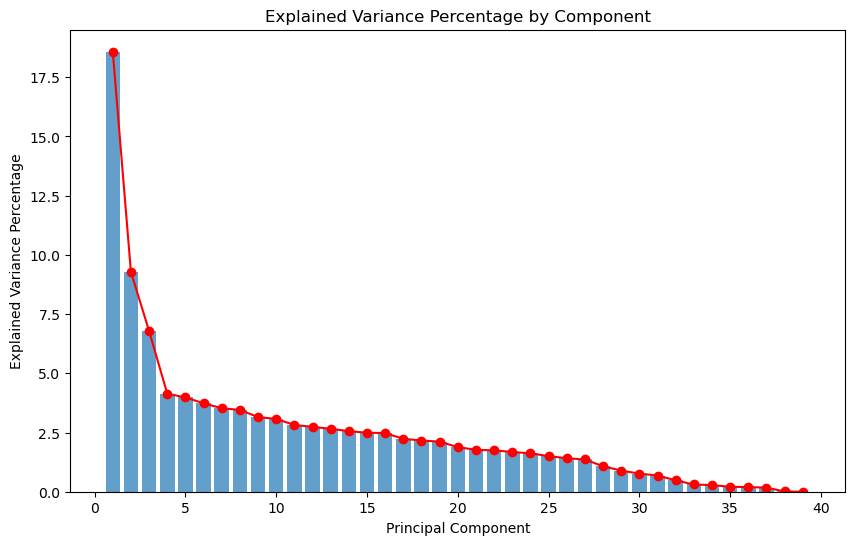

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7)
plt.plot(range(1, len(explained_variance)+1), explained_variance, "o-", color="red")
plt.title("Explained Variance Percentage by Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Percentage")
plt.show()

Here, We cannot use PCA for dimensionality reduction since the variation is spread out over the 39 features

In [33]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=None, n_jobs=-1)

X_umap = reducer.fit_transform(X_scaled)

y = df['Churn']

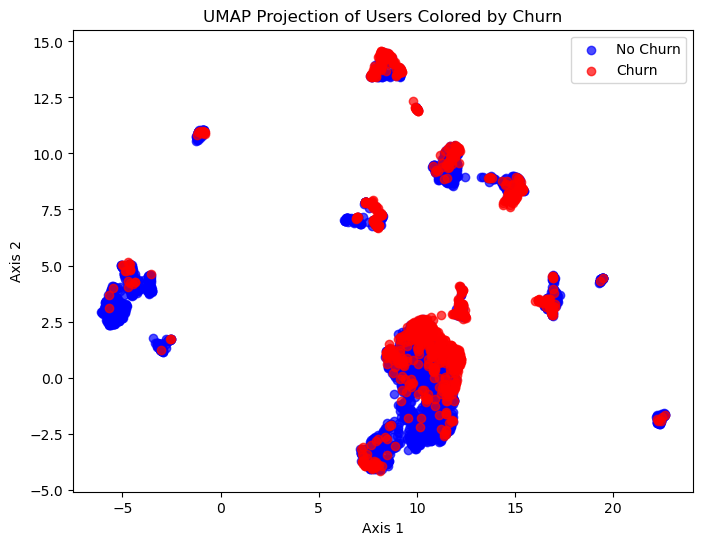

In [34]:
# Plot with discrete colors
plt.figure(figsize=(8,6))
colors = ['blue', 'red']  # 0 = blue, 1 = red
labels = ['No Churn', 'Churn']

for i, label in enumerate([0,1]):
    plt.scatter(X_umap[y==label,0], X_umap[y==label,1], 
                c=colors[i], label=labels[i], alpha=0.7)

plt.xlabel("Axis 1")
plt.ylabel("Axis 2")
plt.title("UMAP Projection of Users Colored by Churn")
plt.legend()
plt.show()

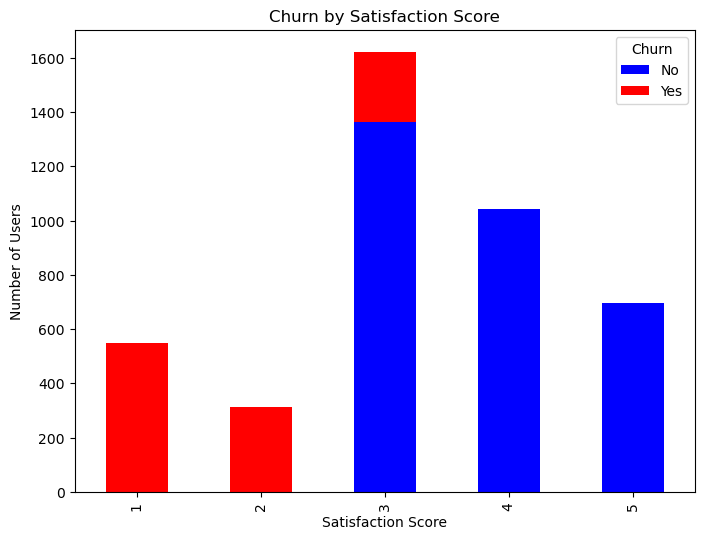

In [35]:
# Pivot table for stacked bars
stack_df = df.pivot_table(index='Satisfaction Score', columns='Churn', aggfunc='size', fill_value=0)

stack_df.plot(kind='bar', stacked=True, color=['blue','red'], figsize=(8,6))
plt.xlabel("Satisfaction Score")
plt.ylabel("Number of Users")
plt.title("Churn by Satisfaction Score")
plt.legend(title='Churn', labels=['No','Yes'])
plt.show()

We can see from this plot that, 
Scores 1–2 → high churn probability
Score 3 → ~12–15% churn probability
Scores 4–5 → very low churn probability
It gives away churn so we will drop it

In [36]:
df = df.drop("Satisfaction Score", axis = 1)

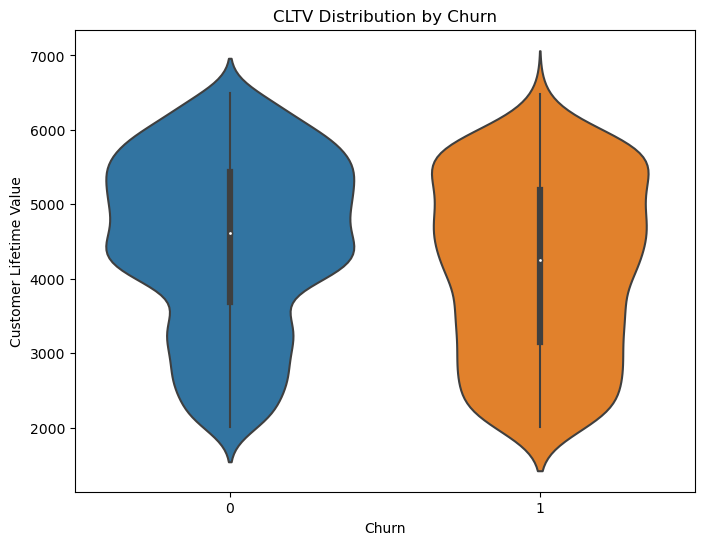

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.violinplot(x='Churn', y='CLTV', data=df)
plt.title("CLTV Distribution by Churn")
plt.xlabel("Churn")
plt.ylabel("Customer Lifetime Value")
plt.show()

Both churned and non-churned customers span a wide range of CLTV values,

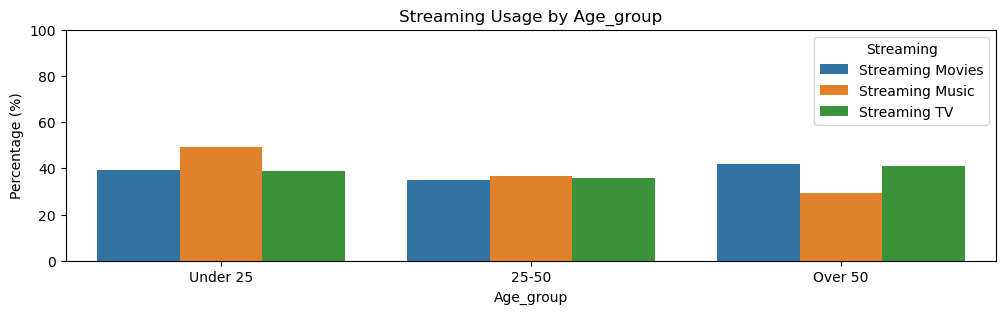

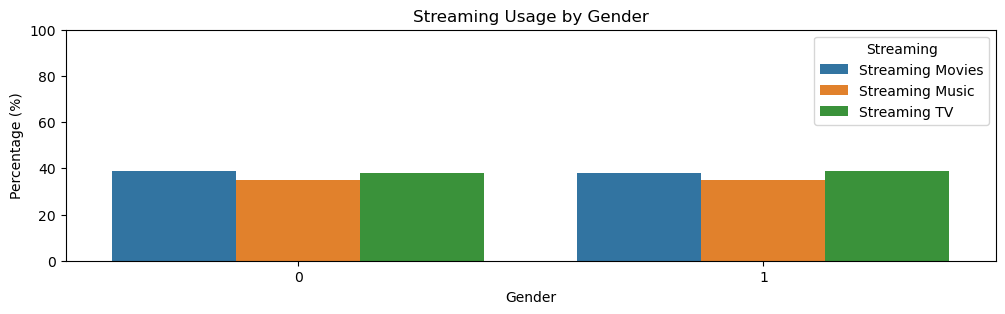

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Streaming features
streaming_features = ['Streaming Movies', 'Streaming Music', 'Streaming TV']

# Demographic features
demographics = {
    'Age_group': pd.cut(df['Age'], bins=[0,25,50,df['Age'].max()+1],
                         labels=['Under 25','25-50','Over 50'], right=False),
    'Gender': df['Gender']
}

# Loop over demographic features
for demo_name, demo_data in demographics.items():
    df[demo_name] = demo_data  # add binned or original column

    # Prepare data for plotting
    plot_data = []
    for stream in streaming_features:
        perc = df.groupby(demo_name, observed=True)[stream].mean() * 100
        temp = perc.reset_index()
        temp['Streaming'] = stream
        temp.rename(columns={stream:'Percentage'}, inplace=True)
        plot_data.append(temp)
    plot_df = pd.concat(plot_data)

    # Plot
    plt.figure(figsize=(12,3))  # compact horizontal plot
    sns.barplot(x=demo_name, y='Percentage', hue='Streaming', data=plot_df)
    plt.title(f"Streaming Usage by {demo_name}")
    plt.ylabel("Percentage (%)")
    plt.ylim(0,100)
    plt.legend(title='Streaming', loc='upper right')
    plt.show()

In [39]:
df.drop('Age_group', axis=1, inplace=True)

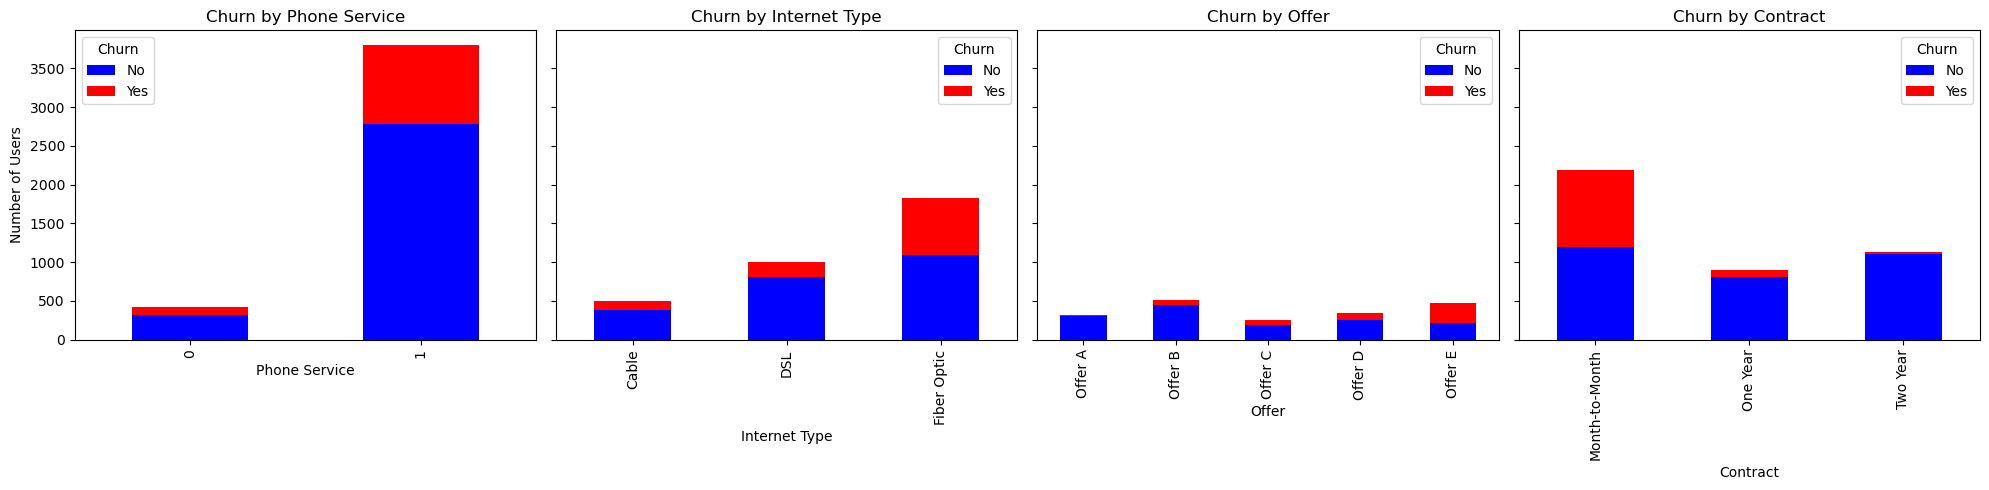

In [40]:
# List of categorical features to plot
features = ['Phone Service', 'Internet Type', 'Offer', 'Contract']

# Set up the figure: 1 row, len(features) columns
fig, axes = plt.subplots(1, len(features), figsize=(5*len(features), 5), sharey=True)

for i, feature in enumerate(features):
    # Pivot table for stacked bar
    stack_df = df_original.pivot_table(index=feature, columns='Churn', aggfunc='size', fill_value=0)
    
    # Plot on the corresponding axis
    stack_df.plot(kind='bar', stacked=True, color=['blue','red'], ax=axes[i])
    axes[i].set_title(f"Churn by {feature}")
    axes[i].set_xlabel(feature)
    if i == 0:
        axes[i].set_ylabel("Number of Users")
    axes[i].legend(title='Churn', labels=['No','Yes'])

plt.tight_layout()
plt.show()

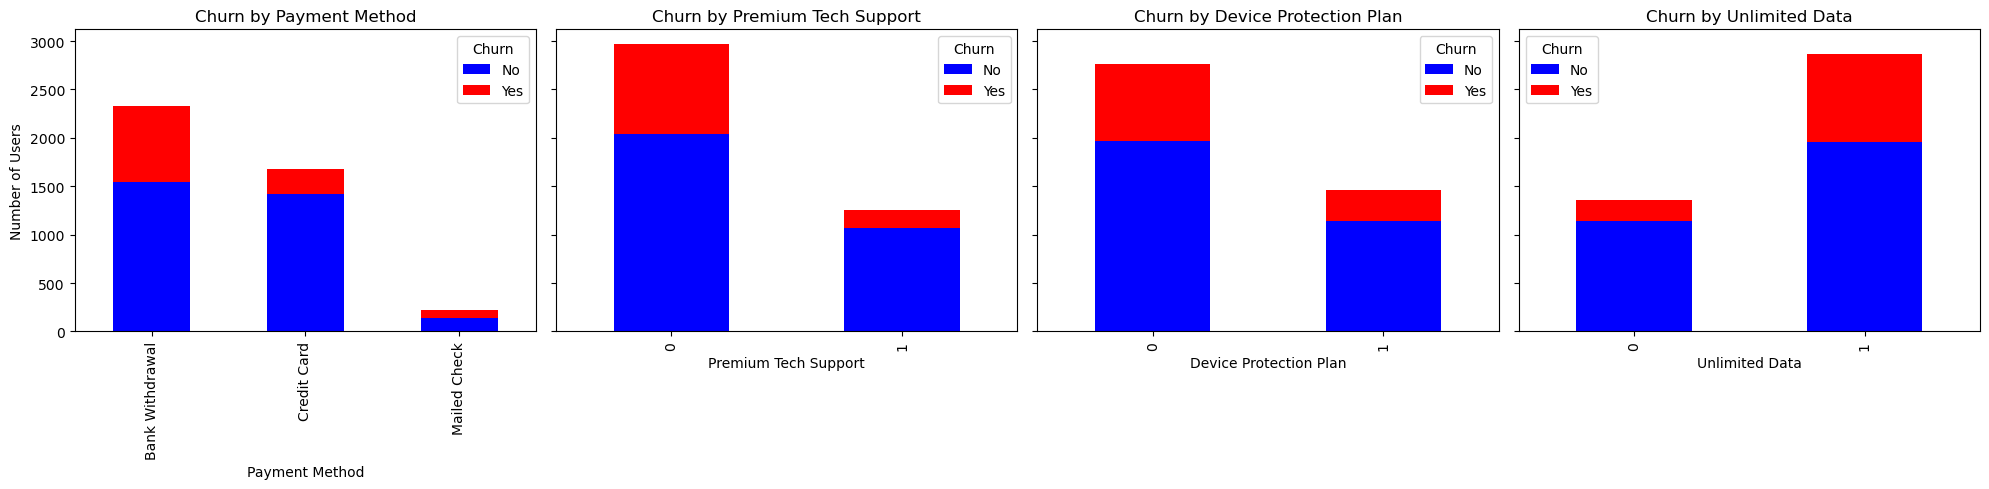

In [41]:
features = ['Payment Method', 'Premium Tech Support', 'Device Protection Plan', 'Unlimited Data']

# Set up the figure: 1 row, len(features) columns
fig, axes = plt.subplots(1, len(features), figsize=(5*len(features), 5), sharey=True)

for i, feature in enumerate(features):
    # Pivot table for stacked bar
    stack_df = df_original.pivot_table(index=feature, columns='Churn', aggfunc='size', fill_value=0)
    
    # Plot on the corresponding axis
    stack_df.plot(kind='bar', stacked=True, color=['blue','red'], ax=axes[i])
    axes[i].set_title(f"Churn by {feature}")
    axes[i].set_xlabel(feature)
    if i == 0:
        axes[i].set_ylabel("Number of Users")
    axes[i].legend(title='Churn', labels=['No','Yes'])

plt.tight_layout()
plt.show()

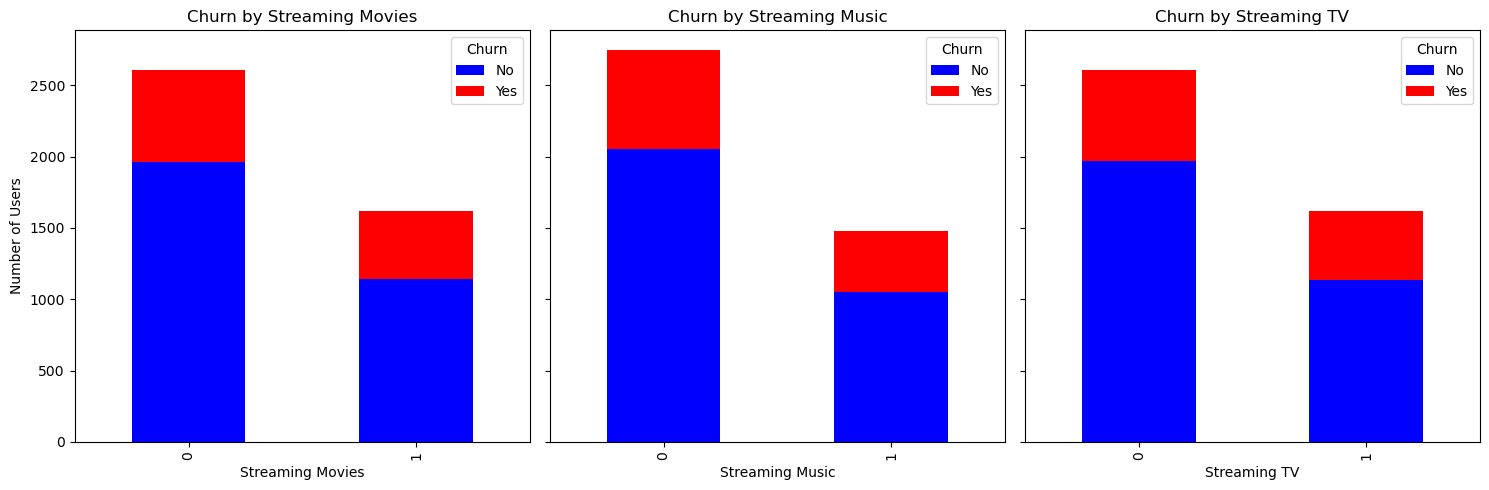

In [42]:
features = ['Streaming Movies', 'Streaming Music', 'Streaming TV']  

# Set up the figure: 1 row, len(features) columns
fig, axes = plt.subplots(1, len(features), figsize=(5*len(features), 5), sharey=True)

for i, feature in enumerate(features):
    # Pivot table for stacked bar
    stack_df = df_original.pivot_table(index=feature, columns='Churn', aggfunc='size', fill_value=0)
    
    # Plot on the corresponding axis
    stack_df.plot(kind='bar', stacked=True, color=['blue','red'], ax=axes[i])
    axes[i].set_title(f"Churn by {feature}")
    axes[i].set_xlabel(feature)
    if i == 0:
        axes[i].set_ylabel("Number of Users")
    axes[i].legend(title='Churn', labels=['No','Yes'])

plt.tight_layout()
plt.show()

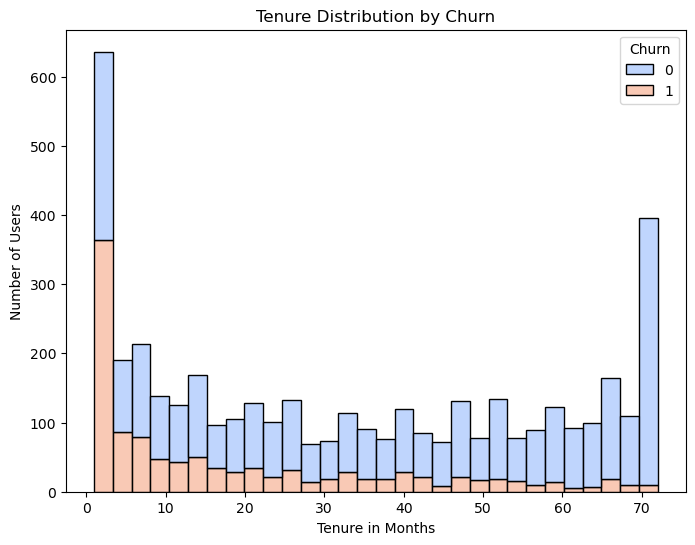

In [43]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='Tenure in Months', hue='Churn', multiple='stack', bins=30, palette='coolwarm')
plt.xlabel("Tenure in Months")
plt.ylabel("Number of Users")
plt.title("Tenure Distribution by Churn")
plt.show()

High churn in first 3 months → new users might not find value immediately or may try the service and leave.
Churn decreases as tenure increases → users who stay past the initial period are more likely to continue using the service.
This is often called the “honeymoon period” problem — early churn is high.

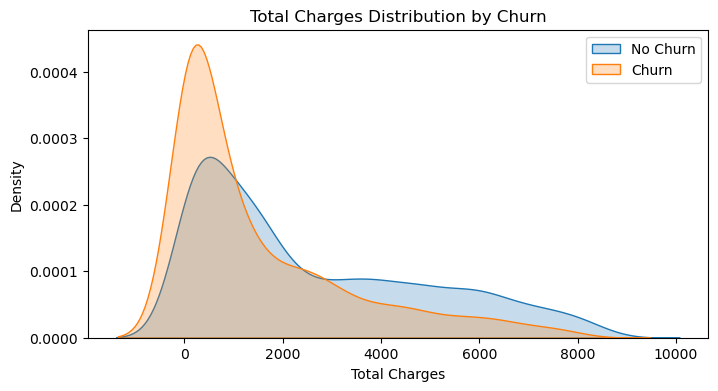

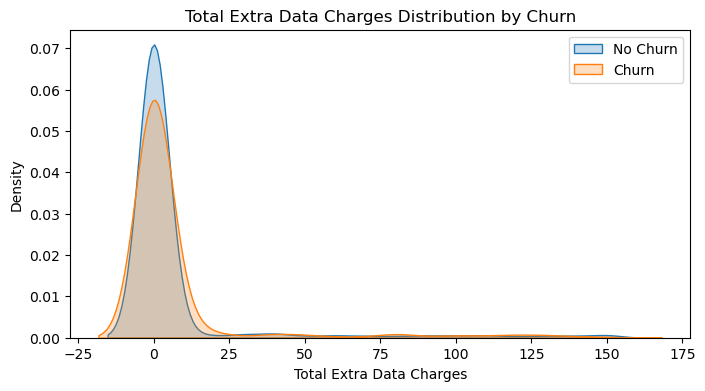

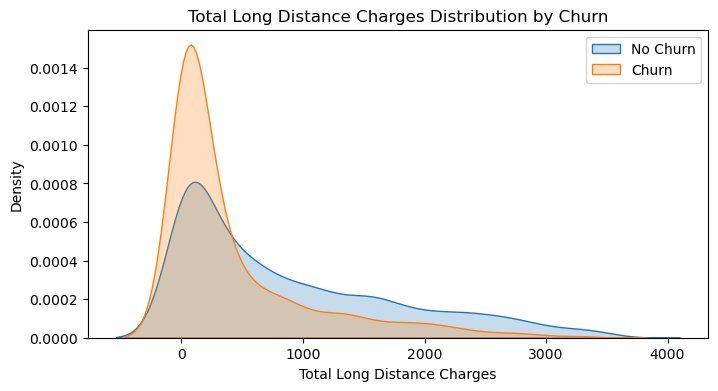

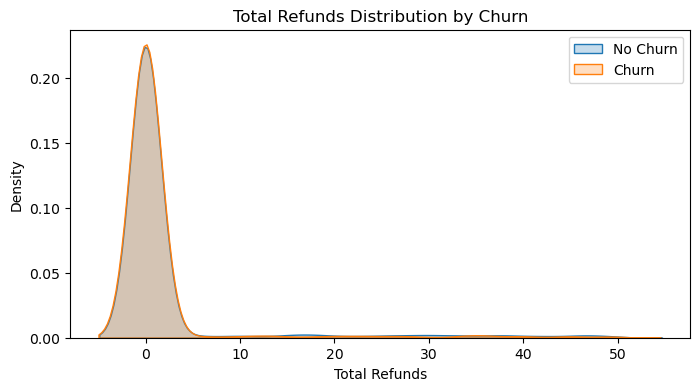

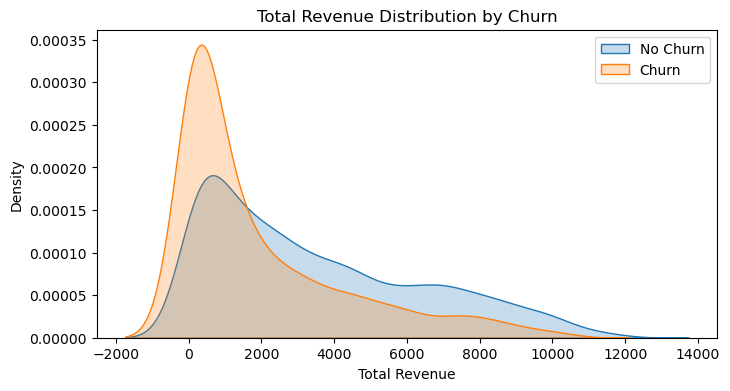

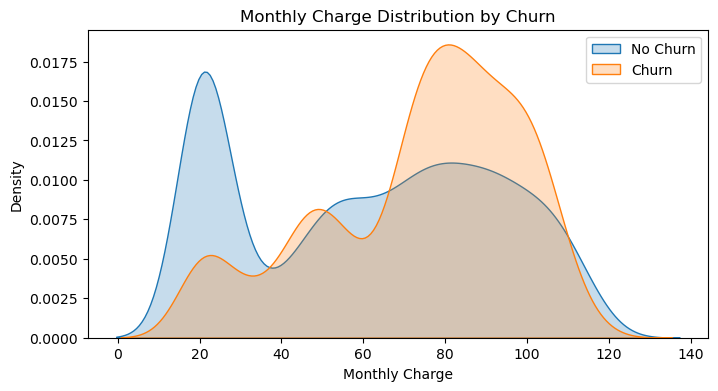

In [44]:
features = ['Total Charges', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Refunds', 'Total Revenue', 'Monthly Charge']
for col in features:
    plt.figure(figsize=(8,4))
    sns.kdeplot(df[df['Churn']==0][col], label='No Churn', fill=True)
    sns.kdeplot(df[df['Churn']==1][col], label='Churn', fill=True)
    plt.title(f"{col} Distribution by Churn")
    plt.legend()
    plt.show()

Total Charges: Low charges users might be new (more likely to churn)
Total Refunds: Refunds usually indicate dissatisfaction → likely correlated with churn
Total Revenue: Usually reflects tenure × charges; low revenue users might be new (more likely to churn)
Monthly Charge: Users with low monthly charge are less likely to churn

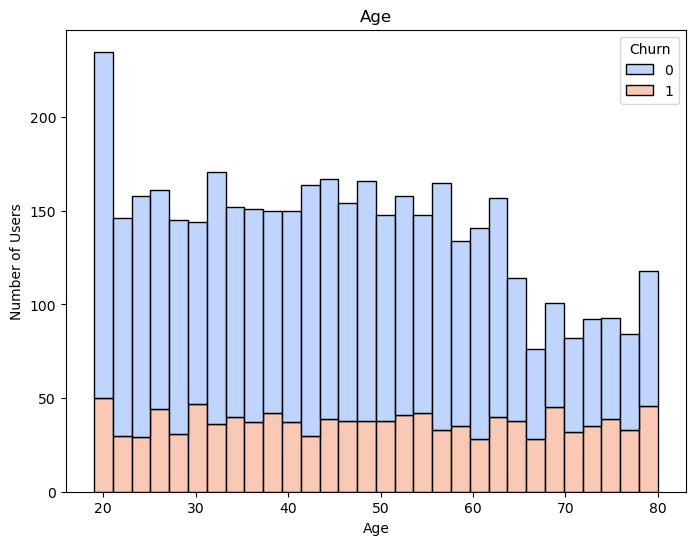

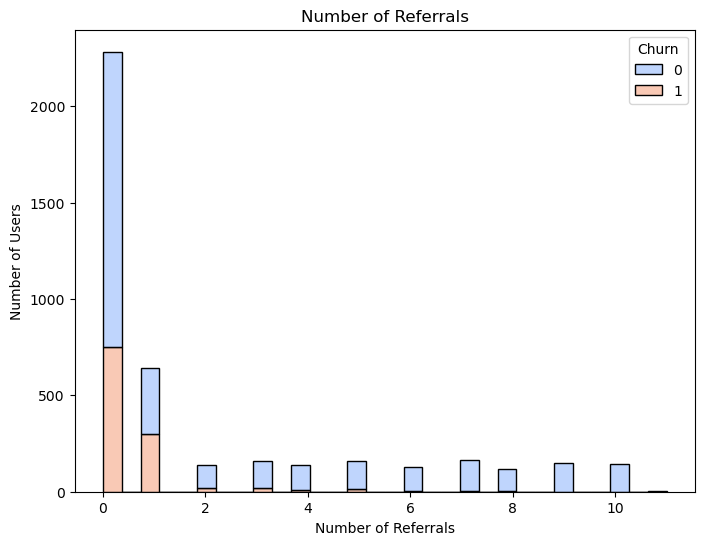

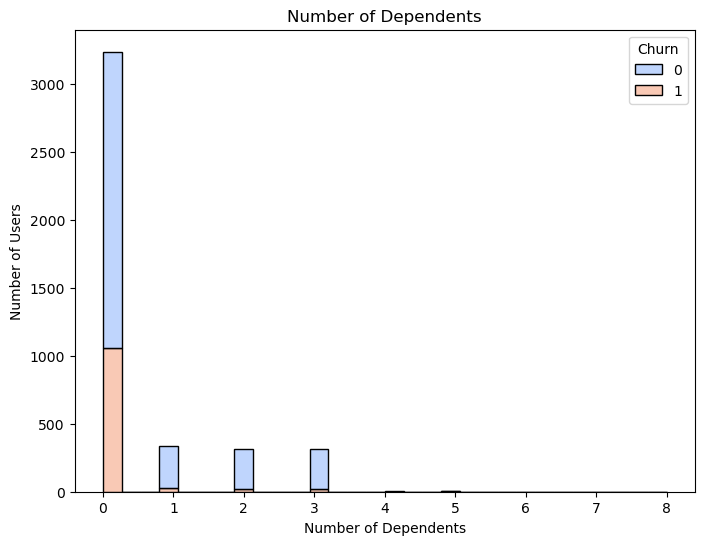

In [45]:
features = ['Age', 'Number of Referrals', 'Number of Dependents']

for feature in features:
    plt.figure(figsize=(8,6))
    sns.histplot(data=df, x=feature, hue='Churn', multiple='stack', bins=30, palette='coolwarm')
    plt.xlabel(f"{feature}")
    plt.ylabel("Number of Users")
    plt.title(f"{feature}")
    plt.show()

Age: Most of the users are of age 19-21
Number of Referrals: Most of the users do not give referrals; Users who are more likely to churn give no or less referrals
Number of Dependents: Most of the users have no dependents; Users with no or few dependents are more likely to churn

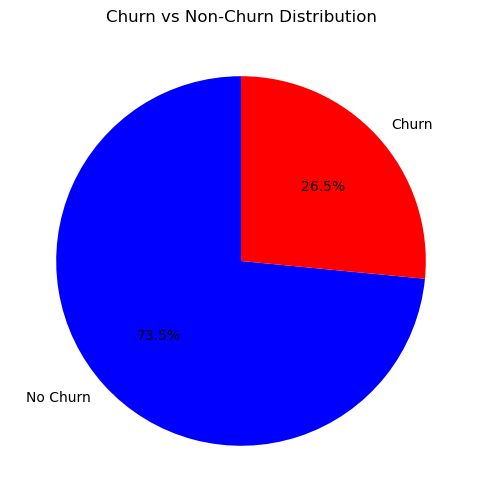

In [46]:
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%', colors=['blue','red'], startangle=90)
plt.title("Churn vs Non-Churn Distribution")
plt.show()

26.5 percent of the total users churn and 73.5 percent of total users stay. Moderately imbalanced dataset

In [47]:
X = df.drop("Churn", axis=1)   # Features
y = df["Churn"]                # Target

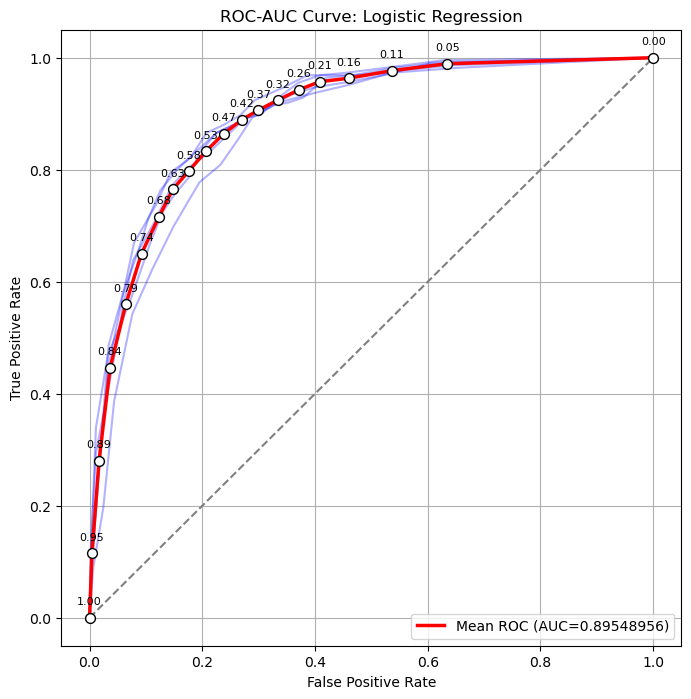

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# X, y are your dataset, with satisfaction_score removed
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = X.values
y = y.values
# Fixed thresholds
num_thresholds = 20
thresholds_fixed = np.linspace(0, 1, num_thresholds)

# Store results
tprs_all = []
fprs_all = []
aucs = []

plt.figure(figsize=(8,8))

for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale per fold
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Logistic Regression with class_weight balanced
    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    # Predict probabilities
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    # Compute ROC for accurate AUC
    fpr_true, tpr_true, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr_true, tpr_true)
    aucs.append(roc_auc)
    
    # Compute TPR/FPR at fixed thresholds
    tpr_thresh = []
    fpr_thresh = []
    for thr in thresholds_fixed:
        y_pred_thr = (y_prob >= thr).astype(int)
        TP = ((y_pred_thr == 1) & (y_test == 1)).sum()
        FP = ((y_pred_thr == 1) & (y_test == 0)).sum()
        FN = ((y_pred_thr == 0) & (y_test == 1)).sum()
        TN = ((y_pred_thr == 0) & (y_test == 0)).sum()
        
        tpr_val = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr_val = FP / (FP + TN) if (FP + TN) > 0 else 0
        
        tpr_thresh.append(tpr_val)
        fpr_thresh.append(fpr_val)
    
    tprs_all.append(tpr_thresh)
    fprs_all.append(fpr_thresh)
    
    # Plot each fold lightly
    plt.plot(fpr_thresh, tpr_thresh, alpha=0.3, color='blue')

# Compute mean TPR/FPR over folds
mean_tpr1 = np.mean(tprs_all, axis=0)
mean_fpr1 = np.mean(fprs_all, axis=0)

# Plot average curve in contrasting color
plt.plot(mean_fpr1, mean_tpr1, color='red', lw=2.5, label=f'Mean ROC (AUC={np.mean(aucs):.8f})')

# Annotate thresholds on average curve
for i, thr in enumerate(thresholds_fixed):
    plt.scatter(mean_fpr1[i], mean_tpr1[i], s=50, facecolors='white', edgecolors='black', zorder=5)
    plt.text(mean_fpr1[i], mean_tpr1[i]+0.02, f'{thr:.2f}', fontsize=8, ha='center', va='bottom', zorder=6)

# Random guess line
plt.plot([0,1],[0,1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve: Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

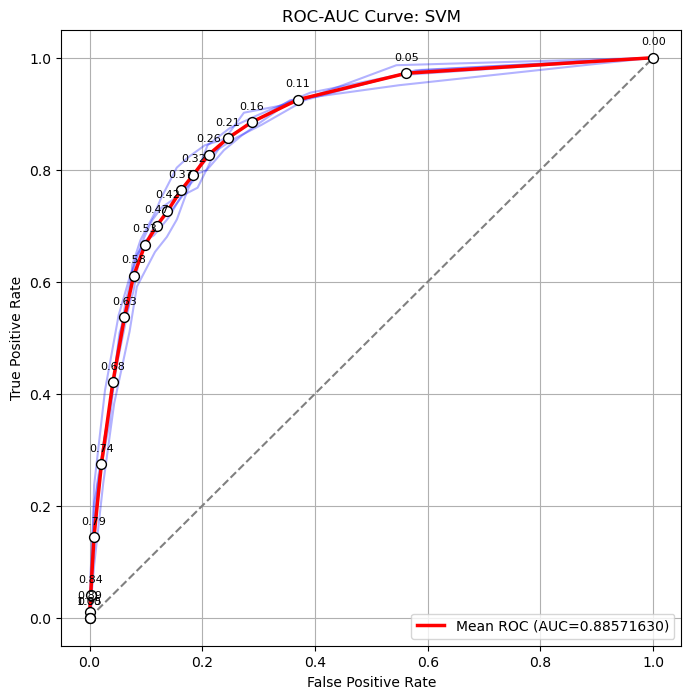

In [49]:
from sklearn.svm import SVC

# Store results
tprs_all = []
fprs_all = []
aucs = []

plt.figure(figsize=(8,8))

for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale per fold
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # SVM with probability output
    clf = SVC(probability=True, class_weight='balanced', kernel='rbf', random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict probabilities for positive class
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    # Compute ROC for accurate AUC
    fpr_true, tpr_true, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr_true, tpr_true)
    aucs.append(roc_auc)
    
    # Compute TPR/FPR at fixed thresholds
    tpr_thresh = []
    fpr_thresh = []
    for thr in thresholds_fixed:
        y_pred_thr = (y_prob >= thr).astype(int)
        TP = ((y_pred_thr == 1) & (y_test == 1)).sum()
        FP = ((y_pred_thr == 1) & (y_test == 0)).sum()
        FN = ((y_pred_thr == 0) & (y_test == 1)).sum()
        TN = ((y_pred_thr == 0) & (y_test == 0)).sum()
        
        tpr_val = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr_val = FP / (FP + TN) if (FP + TN) > 0 else 0
        
        tpr_thresh.append(tpr_val)
        fpr_thresh.append(fpr_val)
    
    tprs_all.append(tpr_thresh)
    fprs_all.append(fpr_thresh)
    
    # Plot each fold lightly
    plt.plot(fpr_thresh, tpr_thresh, alpha=0.3, color='blue')

# Compute mean TPR/FPR over folds
mean_tpr2 = np.mean(tprs_all, axis=0)
mean_fpr2 = np.mean(fprs_all, axis=0)

# Plot average curve in contrasting color
plt.plot(mean_fpr2, mean_tpr2, color='red', lw=2.5, label=f'Mean ROC (AUC={np.mean(aucs):.8f})')

# Plot threshold points as circles and annotate
for i, thr in enumerate(thresholds_fixed):
    plt.scatter(mean_fpr2[i], mean_tpr2[i], s=50, facecolors='white', edgecolors='black', zorder=5)
    plt.text(mean_fpr2[i], mean_tpr2[i]+0.02, f'{thr:.2f}', fontsize=8, ha='center', va='bottom', zorder=6)

# Random guess line
plt.plot([0,1],[0,1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve: SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


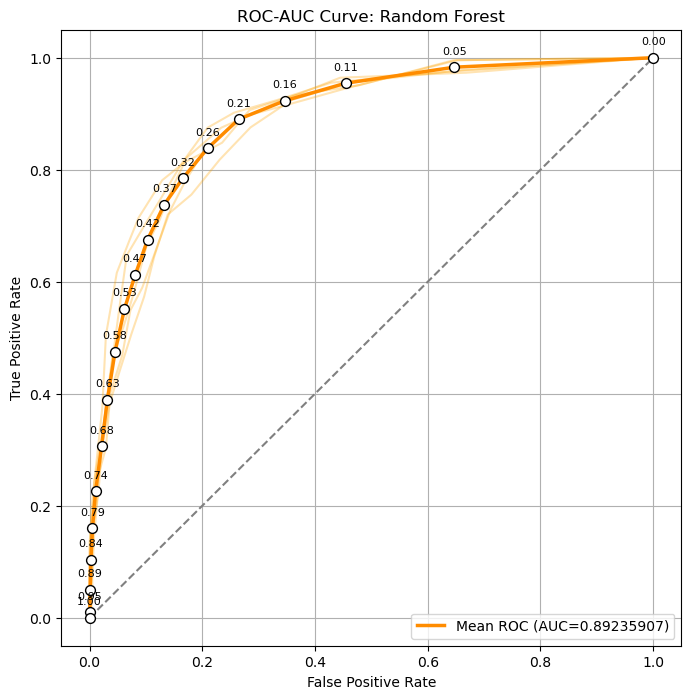

In [50]:
from sklearn.ensemble import RandomForestClassifier

# Store results
tprs_all = []
fprs_all = []
aucs = []

plt.figure(figsize=(8,8))

for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale per fold (optional for RF, not strictly necessary)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Random Forest with balanced class weights
    clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict probabilities for positive class
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    # Compute ROC for accurate AUC
    fpr_true, tpr_true, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr_true, tpr_true)
    aucs.append(roc_auc)
    
    # Compute TPR/FPR at fixed thresholds
    tpr_thresh = []
    fpr_thresh = []
    for thr in thresholds_fixed:
        y_pred_thr = (y_prob >= thr).astype(int)
        TP = ((y_pred_thr == 1) & (y_test == 1)).sum()
        FP = ((y_pred_thr == 1) & (y_test == 0)).sum()
        FN = ((y_pred_thr == 0) & (y_test == 1)).sum()
        TN = ((y_pred_thr == 0) & (y_test == 0)).sum()
        
        tpr_val = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr_val = FP / (FP + TN) if (FP + TN) > 0 else 0
        
        tpr_thresh.append(tpr_val)
        fpr_thresh.append(fpr_val)
    
    tprs_all.append(tpr_thresh)
    fprs_all.append(fpr_thresh)
    
    # Plot each fold lightly
    plt.plot(fpr_thresh, tpr_thresh, alpha=0.3, color='orange')

# Compute mean TPR/FPR over folds
mean_tpr3 = np.mean(tprs_all, axis=0)
mean_fpr3 = np.mean(fprs_all, axis=0)

# Plot average curve in contrasting color
plt.plot(mean_fpr3, mean_tpr3, color='darkorange', lw=2.5, label=f'Mean ROC (AUC={np.mean(aucs):.8f})')

# Plot threshold points as circles and annotate
for i, thr in enumerate(thresholds_fixed):
    plt.scatter(mean_fpr3[i], mean_tpr3[i], s=50, facecolors='white', edgecolors='black', zorder=5)
    plt.text(mean_fpr3[i], mean_tpr3[i]+0.02, f'{thr:.2f}', fontsize=8, ha='center', va='bottom', zorder=6)
    
# Random guess line
plt.plot([0,1],[0,1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve: Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [52]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Base classifier
xgb_clf = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# Parameter search space
param_dist = {
    'n_estimators': [100, 200, 400, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [2.77]  # handle imbalance
}

# Randomized Search CV
rs = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=40,  # number of random combinations to try
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit search
rs.fit(X, y)

# Best parameters
best_params = rs.best_params_
print("Best params:", best_params)
print("Best AUC:", rs.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'subsample': 1.0, 'scale_pos_weight': 2.77, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.6}
Best AUC: 0.9082203340086229


In [55]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': 2.77,  # handle imbalance
        'eval_metric': 'logloss',
        'random_state': 42
    }

    clf = XGBClassifier(**params)
    
    # 5-fold CV for scoring
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    return np.mean(scores)  # objective: maximize mean AUC

# Create study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # 50 iterations of Bayesian search

print("Best trial:", study.best_trial.params)
print("Best AUC Score:", study.best_value)

[I 2025-10-03 18:36:25,797] A new study created in memory with name: no-name-32acfb95-dc6d-47c0-9c06-3441ad801fee
[I 2025-10-03 18:36:27,139] Trial 0 finished with value: 0.8834470624902604 and parameters: {'n_estimators': 143, 'max_depth': 7, 'learning_rate': 0.2717551762060938, 'subsample': 0.6038329793349732, 'colsample_bytree': 0.6300272065909416, 'gamma': 2.1088304608535364, 'min_child_weight': 10}. Best is trial 0 with value: 0.8834470624902604.
[I 2025-10-03 18:36:29,531] Trial 1 finished with value: 0.9052220422686762 and parameters: {'n_estimators': 155, 'max_depth': 8, 'learning_rate': 0.029909088501843588, 'subsample': 0.9910533294678427, 'colsample_bytree': 0.9498482563533289, 'gamma': 3.764925069911016, 'min_child_weight': 1}. Best is trial 1 with value: 0.9052220422686762.
[I 2025-10-03 18:36:31,825] Trial 2 finished with value: 0.9033816781317483 and parameters: {'n_estimators': 168, 'max_depth': 10, 'learning_rate': 0.05139452989000739, 'subsample': 0.723605453549508, '

[I 2025-10-03 18:37:28,586] Trial 24 finished with value: 0.9078390914757675 and parameters: {'n_estimators': 341, 'max_depth': 5, 'learning_rate': 0.014574826995476752, 'subsample': 0.9552015883443226, 'colsample_bytree': 0.7388709289182026, 'gamma': 1.646354577305058, 'min_child_weight': 3}. Best is trial 5 with value: 0.9087478264579948.
[I 2025-10-03 18:37:31,118] Trial 25 finished with value: 0.906153062178588 and parameters: {'n_estimators': 399, 'max_depth': 4, 'learning_rate': 0.060280308003329335, 'subsample': 0.7886650283848007, 'colsample_bytree': 0.6245731527328958, 'gamma': 2.255037611145565, 'min_child_weight': 5}. Best is trial 5 with value: 0.9087478264579948.
[I 2025-10-03 18:37:34,061] Trial 26 finished with value: 0.9082624672558754 and parameters: {'n_estimators': 365, 'max_depth': 6, 'learning_rate': 0.022156622002830747, 'subsample': 0.827391282898702, 'colsample_bytree': 0.687453505321719, 'gamma': 4.9182706923599016, 'min_child_weight': 1}. Best is trial 5 with 

[I 2025-10-03 18:38:09,289] Trial 48 finished with value: 0.9068128898684298 and parameters: {'n_estimators': 299, 'max_depth': 6, 'learning_rate': 0.025753305725868123, 'subsample': 0.9839067282797063, 'colsample_bytree': 0.7955460834093029, 'gamma': 0.04926108382345429, 'min_child_weight': 4}. Best is trial 42 with value: 0.9093113040509955.
[I 2025-10-03 18:38:11,373] Trial 49 finished with value: 0.9083994159858115 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.03317367846638272, 'subsample': 0.9920546634299601, 'colsample_bytree': 0.7816893295015432, 'gamma': 0.27531221099691927, 'min_child_weight': 3}. Best is trial 42 with value: 0.9093113040509955.


Best trial: {'n_estimators': 156, 'max_depth': 4, 'learning_rate': 0.06479297198822212, 'subsample': 0.9975240226258123, 'colsample_bytree': 0.8760180914326388, 'gamma': 0.39565602255340804, 'min_child_weight': 6}
Best AUC Score: 0.9093113040509955


We get a better AUC Score by using Bayesian Optimization(optuna)

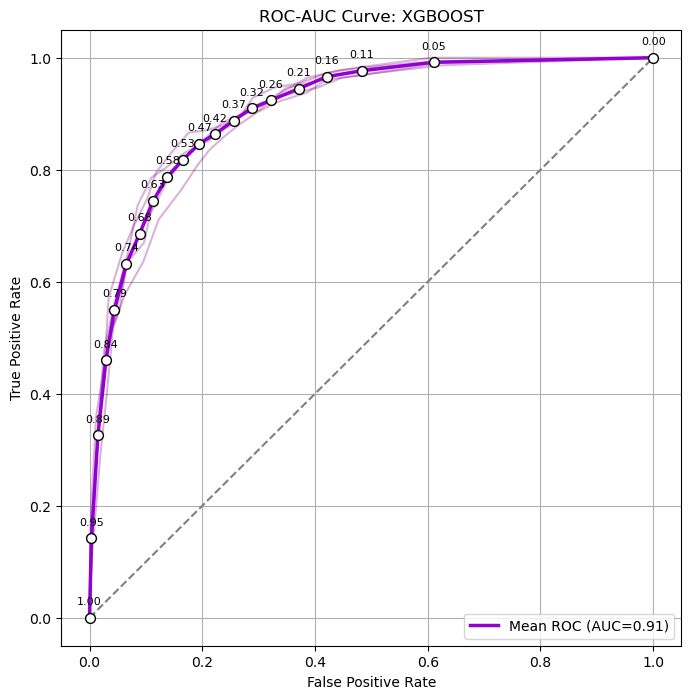

In [56]:
best_params_xgb = study.best_trial.params

# Add necessary fixed parameters
best_params_xgb.update({
    'eval_metric': 'logloss',
    'random_state': 42,
    'scale_pos_weight': 2.77
})

tprs_all = []
fprs_all = []
aucs = []

plt.figure(figsize=(8,8))

for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train XGBoost
    clf = XGBClassifier(**best_params_xgb)
    clf.fit(X_train, y_train)
    
    # Predict probabilities
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    # True ROC for accurate AUC
    fpr_true, tpr_true, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr_true, tpr_true)
    aucs.append(roc_auc)
    
    # Compute TPR/FPR at fixed thresholds
    tpr_thresh, fpr_thresh = [], []
    for thr in thresholds_fixed:
        y_pred_thr = (y_prob >= thr).astype(int)
        TP = ((y_pred_thr == 1) & (y_test == 1)).sum()
        FP = ((y_pred_thr == 1) & (y_test == 0)).sum()
        FN = ((y_pred_thr == 0) & (y_test == 1)).sum()
        TN = ((y_pred_thr == 0) & (y_test == 0)).sum()
        
        tpr_val = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr_val = FP / (FP + TN) if (FP + TN) > 0 else 0
        
        tpr_thresh.append(tpr_val)
        fpr_thresh.append(fpr_val)
    
    tprs_all.append(tpr_thresh)
    fprs_all.append(fpr_thresh)
    
    # Plot each fold lightly
    plt.plot(fpr_thresh, tpr_thresh, alpha=0.3, color='purple')

# Average over folds
mean_tpr4 = np.mean(tprs_all, axis=0)
mean_fpr4 = np.mean(fprs_all, axis=0)

# Plot mean ROC
plt.plot(mean_fpr4, mean_tpr4, color='darkviolet', lw=2.5, label=f'Mean ROC (AUC={np.mean(aucs):.2f})')

# Circles and threshold annotations
for i, thr in enumerate(thresholds_fixed):
    plt.scatter(mean_fpr4[i], mean_tpr4[i], s=50, facecolors='white', edgecolors='black', zorder=5)
    plt.text(mean_fpr4[i], mean_tpr4[i]+0.02, f'{thr:.2f}', fontsize=8, ha='center', va='bottom', zorder=6)

# Random guess line
plt.plot([0,1],[0,1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve: XGBOOST')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

After evaluating multiple models on the dataset using 5-fold cross-validated ROC curves with fixed thresholds, the performance ranking is:
XGBoost > Logistic Regression > Random Forest > SVM

Now, let's pick a threshold:
I don’t want to miss churners → minimize False Negatives (FN).
FN: model predicts “won’t churn” but the customer actually will churn.
To reduce FN, you want a high True Positive Rate (TPR / Recall).

My target TPR is catch 90–95% of churners and I accept the corresponding FPR as trade-off. So, I will pick my threshold as 0.3

### Splitting the Dataset into Train and Test Datasets

We have defined the dataframe with only the column churn as our target variable and the dataframe with the other columns except for churn as our feature variables. Then we used train_test_split() function with 20% test size and 42 random state to create X_train, X_test, y_train and y_test.

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [66]:
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3380, 38) (845, 38) (3380,) (845,)


### Building Our Model
I have used XGBoost to train our model.

In [68]:
selected_threshold = 0.3
best_params_xgb = study.best_trial.params

# Add necessary fixed parameters
best_params_xgb.update({
    'eval_metric': 'logloss',
    'random_state': 42,
    'scale_pos_weight': 2.77
})

final_cl= XGBClassifier(**best_params_xgb)   
grid_final = final_cl.fit(X_train, y_train)
y_prob = final_cl.predict_proba(X_test)[:, 1]
preds = (y_prob >= selected_threshold).astype(int)

In [69]:
acc = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
cm = confusion_matrix(y_test, preds)
report = classification_report(y_test, preds)

print("Model Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Model Accuracy: 0.7798816568047338
Precision: 0.5618556701030928
Recall: 0.9316239316239316
F1 Score: 0.7009646302250804

Confusion Matrix:
 [[441 170]
 [ 16 218]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.72      0.83       611
           1       0.56      0.93      0.70       234

    accuracy                           0.78       845
   macro avg       0.76      0.83      0.76       845
weighted avg       0.85      0.78      0.79       845



True Negatives (TN) = 441 → correctly predicted non-churners
False Positives (FP) = 170 → non-churners predicted as churners (okay trade-off)
False Negatives (FN) = 16 → churners missed (very low!) ✅
True Positives (TP) = 218 → churners correctly identified

Goal achieved: Very few false negatives, high recall (93%) → you’ll catch most churners.
Trade-off: More false positives (170) → non-churners may be flagged, but this is expected when lowering threshold to reduce FN.
Overall: This model is deployable for retention campaigns, especially if your business can tolerate some extra incentives to non-churners.

In [70]:
import shap 

### SHAP(SHapley Additive exPlanations)
To enhance model interpretability, we used SHAP (SHapley Additive exPlanations) to analyze feature importance. SHAP values helped us understand the contribution of each feature to individual predictions, allowing us to identify which variables had the most significant impact on customer churn. This provided valuable insights into the underlying drivers of churn behavior in the dataset.

In [75]:
explainer = shap.TreeExplainer(grid_final)

#Calculate SHAP values for your dataset (typically test set or a sample)
shap_values = explainer.shap_values(X_test)

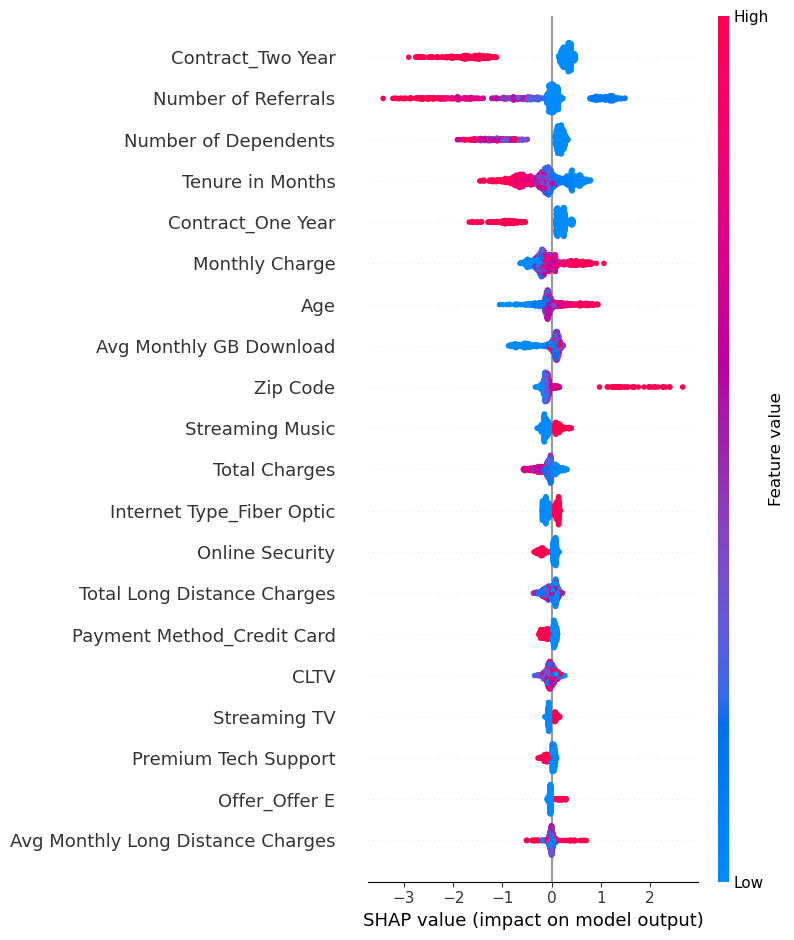

In [76]:
shap.summary_plot(shap_values, X_test)

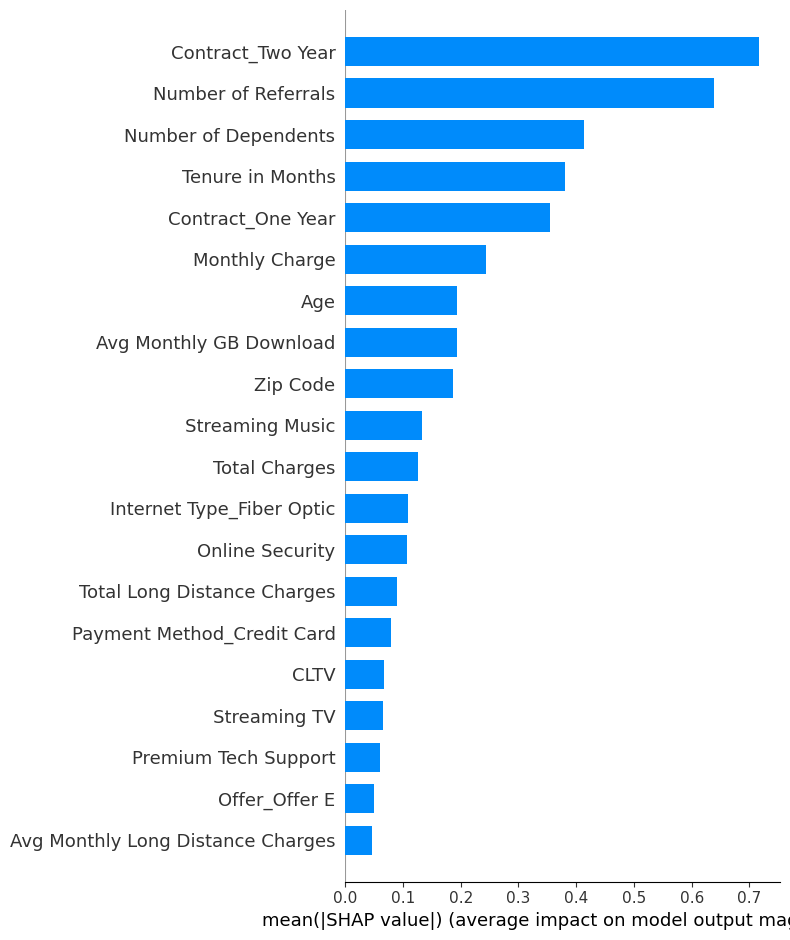

In [77]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

##Business Insights from SHAP Analysis

###1. Contract Type is Crucial:
Customers without a 2-year contract are far more likely to churn.
Actionable Insight: Focus retention campaigns on customers with month-to-month or 1-year contracts—offer long-term incentives or loyalty plans.

###2. High Monthly Charges Drive Churn:
Customers paying higher monthly fees are more likely to leave.
Actionable Insight: Consider discounts, bundling, or tiered plans to reduce perceived cost and increase stickiness.

###3. Tenure Matters:
Longer-tenured customers are less likely to churn.
Actionable Insight: Reward loyalty with perks or exclusive benefits to keep long-term customers engaged.

###4. Referrals Reduce Churn:
Customers with more referrals tend to stay longer.
Actionable Insight: Encourage referral programs—reward customers for bringing in friends/family to increase retention.

Overall Recommendation:
Prioritize customers with short contracts, high monthly charges, and low tenure for churn-prevention campaigns. Leverage referral incentives and loyalty rewards to strengthen retention.